# 415-HW4
## Shuo Han

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import lime
import lime.lime_tabular
import torch
import torch.nn as nn
import os
import time
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import Normalize
from lime import lime_image
from skimage.segmentation import mark_boundaries
import torch.nn.functional as F
from imblearn.over_sampling import SMOTE

## Explainability
### 1

In [2]:
diab = pd.read_csv('/kaggle/input/pima-indians-diabetes-database/diabetes.csv')

diabetic_percentage = (len(diab[diab['Outcome']==1]) / len(diab)) * 100
print("The percentage of patients labeled as diabetic: ", diabetic_percentage, "%")

The percentage of patients labeled as diabetic:  34.89583333333333 %


### 2

In [3]:
# Add an L1 penalty to the lienar regression model
X = diab.drop(columns=['Outcome'], axis=1)
y = diab['Outcome']

smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

# Compare the test-set results with a standard linear model
y_pred = lasso.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE (Lasso):', mse, '\n')

# Print the coefficients
coefficients = pd.Series(lasso.coef_, index=X.columns)
print(coefficients)

MSE (Lasso): 0.16626232800111837 

Pregnancies                 0.003532
Glucose                     0.006139
BloodPressure              -0.002102
SkinThickness              -0.000000
Insulin                    -0.000113
BMI                         0.014336
DiabetesPedigreeFunction    0.000000
Age                         0.005594
dtype: float64


### 3

In [4]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train, y_train)

# Access the feature importances and feature names
feature_importances = rfc.feature_importances_
feature_names = rfc.feature_names_in_

# Print the feature importances and their corresponding feature names
for feature_name, importance in zip(feature_names, feature_importances):
    print(f"{feature_name}: {importance}")

Pregnancies: 0.07138840015284593
Glucose: 0.2358223619596982
BloodPressure: 0.08529879338441
SkinThickness: 0.06952282182804638
Insulin: 0.08133642166952343
BMI: 0.18085194431822288
DiabetesPedigreeFunction: 0.1311189363952113
Age: 0.1446603202920419


### 4

In [5]:
data_point = X.iloc[0]
explainer = lime.lime_tabular.LimeTabularExplainer(training_data=X_train.values,
                                                   mode='classification',
                                                   feature_names=X.columns)

exp = explainer.explain_instance(data_point.values, rfc.predict_proba, num_features=len(X.columns))
exp.show_in_notebook(show_table=True)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### 5

In [6]:
data_point = X.iloc[5]
explainer = lime.lime_tabular.LimeTabularExplainer(training_data=X_train.values,
                                                   mode='classification',
                                                   feature_names=X.columns)

exp = explainer.explain_instance(data_point.values, rfc.predict_proba, num_features=len(X.columns))
exp.show_in_notebook(show_table=True)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### 6

### 7

In [7]:
def load_data(file_path, id_bytes, label_bytes, num_images, height, width, depth):
    """
    Function to load image data from a binary file.
    Parameters:
    file_path (str): Path to the binary file.
    id_bytes (int): Number of bytes used for the image ID.
    label_bytes (int): Number of bytes used for the image label.
    num_images (int): Number of images in the binary file.
    height (int): Height of the images.
    width (int): Width of the images.
    depth (int): Depth of the images (number of color channels).
    Returns:
    images (torch.Tensor): Tensor of image data.
    labels (torch.Tensor): Tensor of image labels.
    """

    # Define the record size in bytes
    record_size = id_bytes + label_bytes + height * width * depth

    # Initialize tensors to store the image IDs, labels, and data
    ids = torch.empty((num_images, id_bytes), dtype=torch.uint8)
    labels = torch.empty((num_images, label_bytes), dtype=torch.uint8)
    images = torch.empty((num_images, depth, height, width), dtype=torch.uint8)

    # Open the binary file and read the contents
    with open(file_path, 'rb') as file:
        for i in range(num_images):
            byte_record = file.read(record_size)

            # Convert the byte string to a tensor
            byte_tensor = torch.tensor(list(byte_record), dtype=torch.uint8)

            # Extract the image ID
            ids[i] = byte_tensor[:id_bytes].view(1, -1)

            # Extract the image label
            labels[i] = byte_tensor[id_bytes:id_bytes + label_bytes].view(1, -1)

            # Extract the image data
            array_image = byte_tensor[id_bytes + label_bytes:record_size].view(depth, height, width)
            images[i] = array_image

    # Ensure labels is a 1-D tensor
    labels = labels[:, -1]

    return images, labels

# Define a normalization function
def normalize(data):
    data = data.to(dtype=torch.float32)
    img_mean = data.mean(dim=(0, 2, 3))
    img_std = data.std(dim=(0, 2, 3))
    normalize = Normalize(img_mean, img_std)
    preprocessed_data = normalize(data)
    return preprocessed_data

if __name__ == '__main__':
    # Specify parameters (information can be found in the readme file)
    id_bytes = 4
    label_bytes = 4
    num_train_files = 1
    num_train_images = 50000
    width = 64
    height = 64
    depth = 3
    num_classes = 10

    # Load training and test data
    train_images, train_labels = load_data('/kaggle/input/hhhhhh/data_batch_1.bin', id_bytes, label_bytes, num_train_images, height, width, depth)

    # Split training data into training and validation sets
    train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.1, random_state=42)
    
    norm_train_images = normalize(train_images)
    norm_val_images = normalize(val_images)
    
    # Print shapes of datasets
    print(train_images.shape)
    print(train_labels.shape)
    print(val_images.shape)
    print(val_labels.shape)

torch.Size([45000, 3, 64, 64])
torch.Size([45000])
torch.Size([5000, 3, 64, 64])
torch.Size([5000])


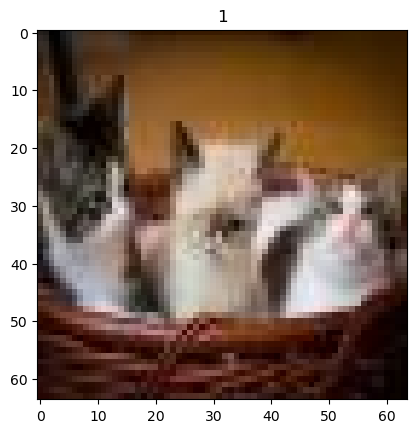

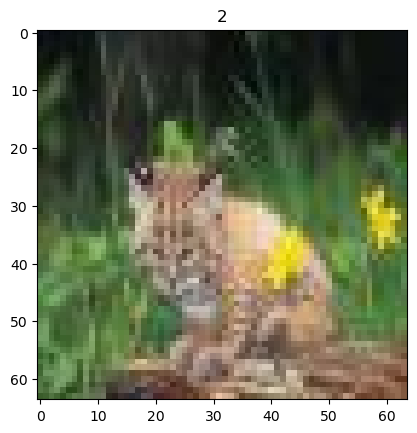

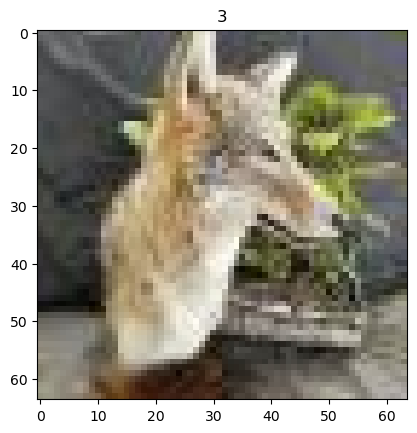

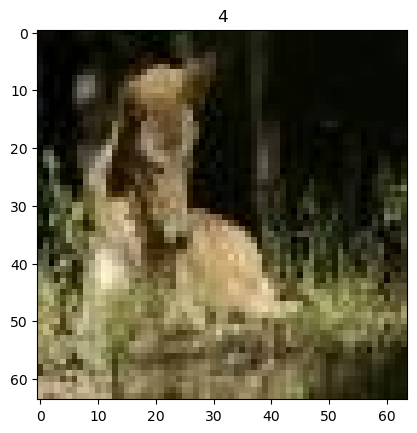

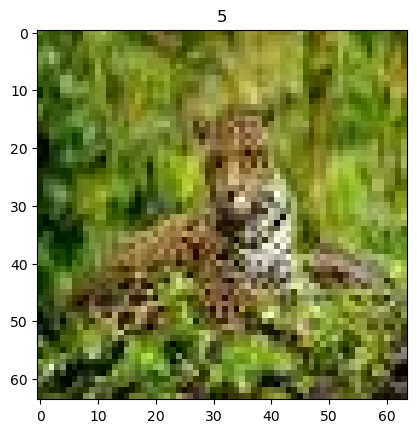

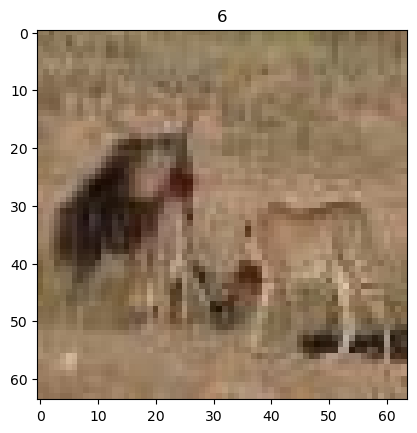

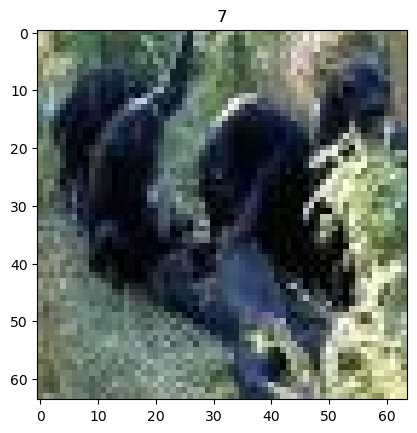

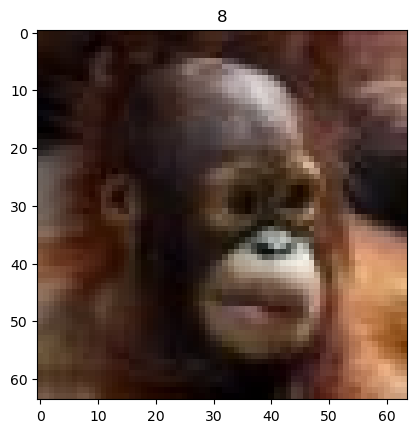

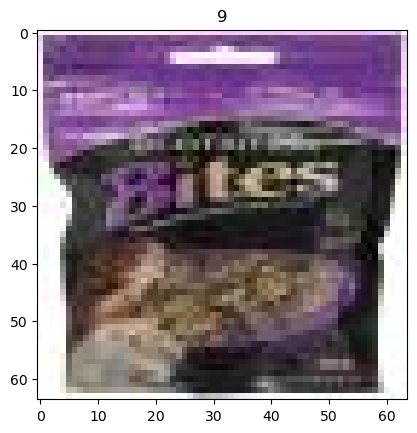

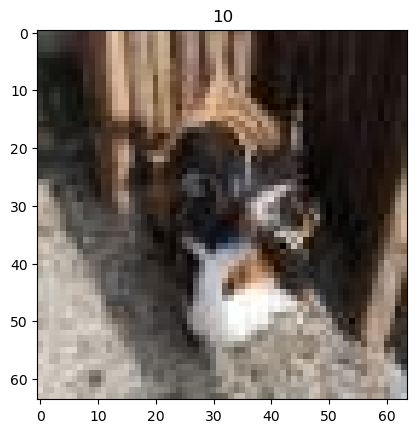

In [8]:
def get_class_name(label):
    class_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']  # Replace with actual class names
    return class_names[label]

unique_labels = torch.unique(train_labels)
for label in unique_labels:
    class_name = get_class_name(label.item())
    class_indices = torch.where(train_labels == label)[0]
    example_image_index = class_indices[0]
    example_image = train_images[example_image_index].permute(1, 2, 0)

    # Display the example image with the corresponding class name
    plt.imshow(example_image)
    plt.title(class_name)
    plt.show()

### 8

In [9]:
def training_loop(model, dataset_train, dataset_val, epochs, batch_size, lr, save_path, model_name_str,
        weight_decay, device):

    # initialize model and move it to the device
    model.to(device)

    # initialize an optimizer to update our model's parameters during training
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # initialize a DataLoader object for each dataset
    train_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

    # a PyTorch categorical cross-entropy loss object
    loss_fn = nn.CrossEntropyLoss()

    # keep track of training and validation accuracy and loss
    train_acc_lst = []
    val_acc_lst = []
    train_loss_lst = []
    val_loss_lst = []

    for epoch_idx in range(epochs):

        best_acc = 0.0

        # loop through the entire dataset once per epoch
        train_loss = 0.0
        train_acc = 0.0
        train_total = 0

        epoch_val_acc_lst = []
        epoch_val_loss_lst = []

        for batch_idx, batch in enumerate(train_dataloader):

            model.train()

            # clear gradients
            optimizer.zero_grad()

            # unpack data and labels
            x, y = batch
            x = x.to(device)
            y = y.to(device)

            # generate predictions and compute loss
            output = model(x.float())  # (batch_size, 10)
            loss = loss_fn(output, y)

            # compute accuracy
            preds = output.argmax(dim=1)
            acc = preds.eq(y).sum().item() / len(y)

            # compute gradients and update model parameters
            loss.backward()
            optimizer.step()

            # update batch training statistics
            train_loss += (loss * len(x))
            train_acc += (acc * len(x))
            train_total += len(x)

            ##########################
            # perform validation every 20 batch
            if batch_idx > 0 and batch_idx % 20 == 0:
                batch_val_loss = 0.0
                batch_val_acc = 0.0
                batch_val_total = 0

                model.eval()
                for val_batch_idx, batch in enumerate(val_dataloader):
                    # don't compute gradients during validation
                    with torch.no_grad():
                        # unpack data and labels
                        x, y = batch
                        x = x.to(device)
                        y = y.to(device)

                        # generate predictions and compute loss
                        output = model(x.float())
                        loss = loss_fn(output, y)

                        # compute accuracy
                        preds = output.argmax(dim=1)
                        acc = preds.eq(y).sum().item() / len(y)

                        # update batch validation statistics
                        batch_val_loss += (loss * len(x))
                        batch_val_acc += (acc * len(x))
                        batch_val_total += len(x)

                batch_val_loss /= batch_val_total
                batch_val_acc /= batch_val_total
                epoch_val_acc_lst.append(batch_val_acc)
                epoch_val_loss_lst.append(batch_val_loss.detach().cpu().numpy().item())

                if batch_val_acc > best_acc:
                    best_acc = batch_val_acc
                    best_model_save_path = save_path + model_name_str + ".pt"
                    
                    torch.save(model.state_dict(), best_model_save_path)



        # update epoch training statistics
        train_loss /= train_total
        train_acc /= train_total
        train_acc_lst.append(train_acc)
        train_loss_lst.append(train_loss.detach().cpu().numpy().item())

        # update epoch validation statistics
        val_acc = np.mean(epoch_val_acc_lst)
        val_loss = np.mean(epoch_val_loss_lst)
        val_acc_lst.append(val_acc)
        val_loss_lst.append(val_loss)

    return model, best_model_save_path, device, train_acc_lst, val_acc_lst, train_loss_lst, val_loss_lst

class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=12288, out_features=10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        return self.linear(x)

epochs = 30
learning_rate = 0.001
lin_model = LinearModel()
weight_decay = 3e-4
batch_size = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = TensorDataset(train_images.float(), train_labels.long())
val_dataset = TensorDataset(val_images.float(), val_labels.long())

linear_model, linear_best_model_save_path, device, linear_train_acc, linear_val_acc, linear_train_loss, linear_val_loss = training_loop(
    model=lin_model,
    dataset_train=train_dataset,
    dataset_val=val_dataset,
    epochs=epochs,
    batch_size=batch_size,
    lr=learning_rate,
    save_path="./",
    model_name_str='LinearModel',
    weight_decay=weight_decay,
    device=device)


### 9

In [10]:
# Define the architecture of your CNN. You will need to fill in the blanks!
# Think about what the input and output of each layer should be
class VanillaCNN(nn.Module):
    def __init__(self):
        super(VanillaCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=64 * 16 * 16, out_features=128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

# initialize a model
model = VanillaCNN()
epochs = 30
batch_size = 64
learning_rate = 0.001
weight_decay = 3e-4

# train the model
model, best_model_save_path, device, train_acc, val_acc, train_loss, val_loss = training_loop(
    model=model,
    dataset_train=train_dataset,
    dataset_val=val_dataset,
    epochs=epochs,
    batch_size=batch_size,
    lr=learning_rate,
    save_path="./",
    model_name_str='vanilla',
    weight_decay=weight_decay,
    device=device)

### 10

In [11]:
class VanillaCNN2(nn.Module):
    def __init__(self):
        super(VanillaCNN2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=128 * 8 * 8, out_features=256)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=256, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
        return x

# initialize a model
model = VanillaCNN2()
epochs = 30
batch_size = 128
learning_rate = 0.001
eight_decay = 3e-4

# train the model
model, best_model_save_path, device, train_acc, tune_val_acc, train_loss, val_tune_loss = training_loop(
    model=model,
    dataset_train=train_dataset,
    dataset_val=val_dataset,
        epochs=epochs,
    batch_size=batch_size,
    lr=learning_rate,
        save_path="./",
        model_name_str='tune',
        weight_decay=weight_decay,
        device=device)

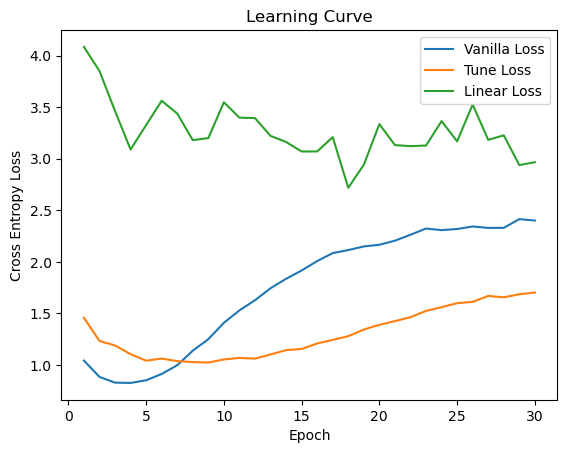

In [13]:
epochs = range(1, epochs + 1)

# Plotting the learning curve
plt.plot(epochs, val_loss, label='Vanilla Loss')
plt.plot(epochs, val_tune_loss, label='Tune Loss')
plt.plot(epochs, linear_val_loss, label='Linear Loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

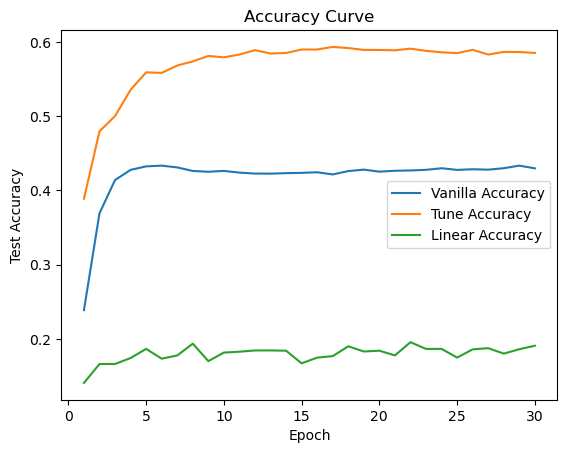

In [14]:
# Plotting the learning curve
plt.plot(epochs, val_acc, label='Vanilla Accuracy')
plt.plot(epochs, tune_val_acc, label='Tune Accuracy')
plt.plot(epochs, linear_val_acc, label='Linear Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

### 11

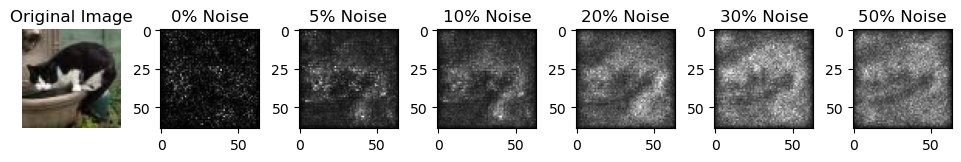

In [15]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

class VanillaGrad:
    """ Class for computing gradients of the output w.r.t an input image for a pretrained model """

    def __init__(self, pretrained_model, cuda=False):
        self.pretrained_model = pretrained_model
        self.cuda = cuda

    def __call__(self, x, index=None):
        x.requires_grad_(True)
        output = self.pretrained_model(x)

        # If no index is provided, select the class with the highest probability
        if index is None:
            index = output.argmax(dim=1).item()

        one_hot = torch.zeros_like(output)
        one_hot[:, index] = 1
        one_hot = one_hot.to(x.device) if self.cuda else one_hot

        # Zero gradients
        self.pretrained_model.zero_grad()
        output.backward(gradient=one_hot)
        grad = x.grad.data

        return grad


class SmoothGrad(VanillaGrad):
    """ Class for computing SmoothGrad, which averages gradients of the output w.r.t input image over
        multiple noisy versions of the input """

    def __init__(self, pretrained_model, cuda=False, stdev_spread=0.15, n_samples=25, magnitude=True):
        super(SmoothGrad, self).__init__(pretrained_model, cuda)
        self.stdev_spread = stdev_spread
        self.n_samples = n_samples
        self.magnitude = magnitude

    def __call__(self, x, index=None):
        stdev = self.stdev_spread * (x.max() - x.min())
        total_gradients = torch.zeros_like(x)

        for _ in range(self.n_samples):
            noise = torch.normal(0, stdev, size=x.shape).to(x.device) if self.cuda else torch.normal(0, stdev, size=x.shape)
            x_plus_noise = x + noise

            grad = super(SmoothGrad, self).__call__(x_plus_noise, index=index)

            if self.magnitude:
                total_gradients += (grad * grad)
            else:
                total_gradients += grad

        avg_gradients = total_gradients / self.n_samples
        return avg_gradients


if __name__ == '__main__':
    # Initialize your model by calling the class that defines your model architecture.
    # Here, 'ExampleCNN' is a placeholder for your model choice.
    model = VanillaCNN2()

    # The weights from your pretrained model should be saved in a .pt file.
    model_weights = "aved_models/E9B80_model.pt"

    # Uncomment the following line to load the weights into the model.
    # 'torch.load' will load the weights, and 'model.load_state_dict' will apply these weights to your model.
    # Make sure that the architecture of 'model' matches the architecture of the model that the weights came from.
    # model.load_state_dict(torch.load(model_weights))

    # Set the model to evaluation mode.
    # This step is necessary because it tells your model that it will be used for inference, not training.
    # In evaluation mode, certain layers like dropout are disabled.
    model.eval()

    # Initialize SmoothGrad. It will average the gradients over 25 noisy versions of the input. Each noisy version is
    # obtained by adding Gaussian noise to the input with a standard deviation of 15% of the input's range.
    # You can change these numbers to vary noise levels and number of images for averaging.
    fig = plt.figure(figsize=(12, 6))
    fig.subplots_adjust(wspace=0.4)
    plt1 = fig.add_subplot(1, 7, 1)
    plt1.set_title("Original Image")
    plt1.imshow(train_images[160].permute(1, 2, 0))
    plt1.axis('off')
    
    levels = [0, 0.05, 0.10, 0.20, 0.30, 0.50]
    for i, noise_level in enumerate(levels, start=2):
        smooth_grad = SmoothGrad(pretrained_model=model, cuda=False, stdev_spread=noise_level, n_samples=25, magnitude=True)

        # Here, you will need to replace 'YOUR_IMAGE_TENSOR' with your actual image tensor. Something like norm_train_images[0].
        example_image = train_images[160]

        # Compute the SmoothGrad saliency map
        # The image tensor is unsqueezed to add an extra dimension because the model expects a batch of images.
        # The dtype is set to float32, as the model expects input data in this format.
        smooth_saliency = smooth_grad(example_image.to(dtype=torch.float32).unsqueeze(0))

        # Convert the saliency map to absolute values, because we are interested in the magnitude of the gradients,
        # regardless of their direction.
        abs_saliency = np.abs(smooth_saliency.numpy())

        # Sum the absolute gradients across all color channels to get a single saliency map.
        # 'squeeze' is used to remove the extra dimension that was added earlier.
        saliency_map = np.sum(abs_saliency, axis=1).squeeze()

        # Display the final saliency map. The brighter a pixel in the saliency map, the more important it is for the model's decision.
        plt2 = fig.add_subplot(1, 7, i)
        plt2.set_title("{:.0%} Noise".format(noise_level))
        plt2.imshow(saliency_map, cmap='gray')
        
    fig.show()

### 12

  0%|          | 0/1000 [00:00<?, ?it/s]

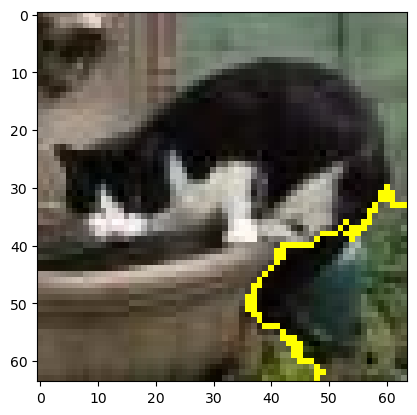

In [18]:
# Placeholder CNN model for illustration. Replace this with your actual model.
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(6 * 64 * 64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.reshape(-1, 6 * 64 * 64)  # Use view instead of reshape for clarity
        x = self.fc1(x)
        return x


# Function to predict model output given images and the model
def predict_fn(images, model):
    images = torch.from_numpy(images).permute(0, 3, 1, 2).float().to(device)
    logits = model(images)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()


# Function to rescale image values to be within 0-1 range.
# This is necessary because 'mark_boundaries' function expects image pixel values between 0 and 1.
def rescale_image(image):
    image_min = image.min()
    image_max = image.max()
    image = (image - image_min) / (image_max - image_min + 1e-5)
    return image


if __name__ == '__main__':
    # Initialize the model
    model = VanillaCNN2()

    # Load your pre-trained model weights here
    # model.load_state_dict(torch.load('path_to_your_model_weights.pt'))

    # Set the model to evaluation mode.
    model.eval()

    # Define the device for the model
    device = torch.device('cpu')
    model.to(device)

    # Initialize LIME explainer
    explainer = lime_image.LimeImageExplainer()

    # Here, you will need to replace 'YOUR_IMAGE_TENSOR' with your actual image tensor. Something like norm_train_images[0].
    example_image = train_images[160]

    # Convert image to numpy and make it suitable for LIME
    test_image = example_image.permute(1, 2, 0).numpy()

    # Generate explanations
    explanation = explainer.explain_instance(test_image,
                                             lambda x: predict_fn(x, model),
                                             top_labels=5,
                                             hide_color=0,
                                             num_samples=1000)

    # Get mask for the first prediction
    # positive_only: Only use "positive" features - ones that increase the prediction probability
    # num_features: The number of superpixels to include in the explanation
    # hide_rest: If true, the non-explanation part of the image is greyed out
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                positive_only=True,
                                                num_features=10,
                                                hide_rest=False)

    # Normalize the image for visualization
    normalized_img = rescale_image(temp)

    # Visualize the explanation
    plt.imshow(mark_boundaries(normalized_img, mask))
    plt.show()  # Show the plot